# Introduction
This is a simple image classifier using the CIFAR-10 dataset.

# Step 1
Installing PyTorch and TorchVision for building the machine learning model and Matplotlib for ploting the results.

In [ ]:
!pip install torch torchvision matplotlib

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

# Step 2
Importing the necessary libraries

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim

# Check if CUDA is available
if torch.cuda.is_available():
    print(f"CUDA is available! Device: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Check runtime settings.")

CUDA is available! Device: Tesla T4


# Step 3
Loading the CIFAR-10 dataset

In [ ]:
# Define transformations for the training and test sets
transform = transforms.Compose(
    [transforms.ToTensor(), # converts a PIL image to a tensor and transforms the values {0,...255} --> [0, 1]
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # first tuple -> means, second tuple -> std's. output=(input-mean)/std
# The image has three color channels (RGB) and therefore the tuples have three elements, one for each color


# Download and load the training data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

# Download and load the test data
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

# Define class names
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Assuming 'net' is your model and 'inputs', 'labels' are your data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

100%|██████████| 170498071/170498071 [00:05<00:00, 29640514.27it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Step 4
Exploring the Data - visualize a few images from the dataset to understand what you are working with:

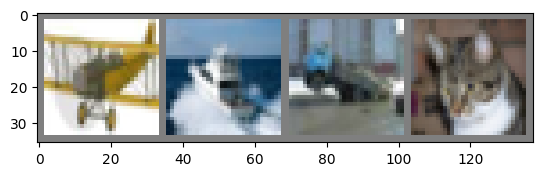

plane ship truck cat


In [26]:
# Functions to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize - [-1,1] --> [0,1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join(f'{classes[labels[j]]}' for j in range(4)))

# Step 5
Build the CNN Model and define the architecture.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)       # num of input channels (3-RGB), num of output channels (6), kernel size (5x5)
        self.pool = nn.MaxPool2d(2, 2)        # kernel size (2x2), stride (step size, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)      # num of input channels (6-from conv1), num of output channels (16), kernel size (5x5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # 16 * 5 * 5 input features (flattened output of the last convolutional layer), 120 output features
        self.fc2 = nn.Linear(120, 84)         # -||-
        self.fc3 = nn.Linear(84, 10)          # -||-
        # Note - num of channels is the number of so-called 'filters'

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5) # flattening of the tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        # Data flow:      x      ->   conv1    ->  relu  ->   pool    ->   conv2    ->  relu  ->   pool   -> view  ->  fc1  -> relu  -> fc2  -> relu  -> fc3
        # Shape of x: N×3×32×32  ->  N×6×28×28 ->  const -> N×6×14×14 -> N×16×10×10 ->  const -> N×16×5×5 -> N×400 -> N×120 -> const -> N×84 -> const -> N×10

net = Net()

# Assuming 'net' is your model and 'inputs', 'labels' are your data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Move model to the device (GPU or CPU)
net.to(device)

# Example of moving tensors to GPU
# inputs, labels = inputs.to(device), labels.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

# Step 6
Define a Loss Function and Optimizer:

In [ ]:
import torch.nn.functional as F

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Step 7
Train the Model

In [ ]:
for epoch in range(5):  # example with 5 epochs

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1, 2000] loss: 1.232
[1, 4000] loss: 1.223
[1, 6000] loss: 1.220
[1, 8000] loss: 1.206
[1, 10000] loss: 1.199
[1, 12000] loss: 1.180
[2, 2000] loss: 1.128
[2, 4000] loss: 1.128
[2, 6000] loss: 1.113
[2, 8000] loss: 1.129
[2, 10000] loss: 1.115
[2, 12000] loss: 1.122
[3, 2000] loss: 1.040
[3, 4000] loss: 1.058
[3, 6000] loss: 1.047
[3, 8000] loss: 1.061
[3, 10000] loss: 1.044
[3, 12000] loss: 1.046
[4, 2000] loss: 0.959
[4, 4000] loss: 1.002
[4, 6000] loss: 0.996
[4, 8000] loss: 1.005
[4, 10000] loss: 1.001
[4, 12000] loss: 1.030
[5, 2000] loss: 0.921
[5, 4000] loss: 0.941
[5, 6000] loss: 0.926
[5, 8000] loss: 0.956
[5, 10000] loss: 0.963
[5, 12000] loss: 0.971
Finished Training


# Testing
Evaluate the model's performance on the test data:

In [ ]:
correct = 0
total = 0

# We do not need to track gradients for evaluation
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        # Forward pass
        outputs = net(images)

        # Get the predicted class with the highest score
        _, predicted = torch.max(outputs.data, 1)

        # Update total and correct counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print accuracy
print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')


Accuracy of the network on the 10000 test images: 62.08 %


Here is a nice visualization for the predictions on a batch of data:

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Ensure the model is on the GPU
net.to(device)

dataiter = iter(testloader)

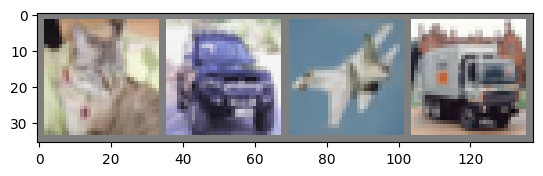

GroundTruth:  cat car plane truck
Predicted:  cat car plane truck


In [ ]:
images, labels = next(dataiter)

# Move the inputs and labels to the GPU
images, labels = images.to(device), labels.to(device)

# Print images
imshow(torchvision.utils.make_grid(images.cpu()))  # Move images back to CPU for visualization
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]}' for j in range(4)))

# Get predictions from the model
outputs = net(images)

# Get the predicted class with the highest score
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]}' for j in range(4)))